In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf


from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(42)

In [14]:
#Check to see if tensorflow is with GPU 
# Source: https://medium.com/mlearning-ai/install-tensorflow-on-mac-m1-m2-with-gpu-support-c404c6cfb580
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.0-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.11 | packaged by conda-forge | (main, May 10 2023, 19:01:19) [Clang 14.0.6 ]
Pandas 2.0.1
Scikit-Learn 1.2.2
SciPy 1.10.1
GPU is available


Each image is a 256 X 256 jpg image of human face either real or fake

In [3]:
base_path = '../deepfake-detector/Dataset'
image_shape = img_to_array(load_img(base_path + '/Train/Real/real_0.jpg')).shape
print(image_shape)
w = image_shape[0]
h = image_shape[1]

(256, 256, 3)


In [4]:
train = image_dataset_from_directory(
    base_path + '/Train',
    image_size=(256,256),
    batch_size=32,
    seed=42,
    label_mode='binary'
)

val = image_dataset_from_directory(
    base_path + '/Validation',
    image_size=(256,256),
    batch_size=32,
    seed=42,
    label_mode='binary'
)

test = image_dataset_from_directory(
    base_path + '/Test',
    image_size=(256,256),
    batch_size=32,
    label_mode='binary'
)

Found 140002 files belonging to 2 classes.
Metal device set to: Apple M2 Max
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [5]:
train.class_names, train.file_paths[:5]

(['Fake', 'Real'],
 ['../deepfake-detector/Dataset/Train/Real/real_50275.jpg',
  '../deepfake-detector/Dataset/Train/Real/real_39190.jpg',
  '../deepfake-detector/Dataset/Train/Real/real_8044.jpg',
  '../deepfake-detector/Dataset/Train/Fake/fake_29481.jpg',
  '../deepfake-detector/Dataset/Train/Real/real_30293.jpg'])

In [6]:
type(train)

tensorflow.python.data.ops.batch_op._BatchDataset

# Model 1

In [ ]:
model = Sequential()

model.add(layers.Input(shape = (256,256,3)))
#normalize pixel and preprocess images in network
model.add(layers.Rescaling(1./255))


#First Convolution layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
#MaxPooling
model.add(MaxPooling2D(pool_size = (2,2)))


# 2nd Convolution layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#To feed this into our model, we need to flatten
model.add(Flatten())

#Fully connected layer
# 1 Hidden Layer
model.add(Dense(64, activation = 'relu'))

#Output Layer
model.add(Dense(1, activation = 'sigmoid'))


# Compile
model.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc']
)

# Let's train the model by fitting it
h1 = model.fit(train, validation_data = val, epochs = 5)

Epoch 1/5
4376/4376 [==============================] - 381s 84ms/step - loss: 0.4139 - acc: 0.8042 - val_loss: 0.4144 - val_acc: 0.8013
Epoch 2/5
4376/4376 [==============================] - 364s 83ms/step - loss: 0.2744 - acc: 0.8786 - val_loss: 0.3698 - val_acc: 0.8336
Epoch 3/5
4376/4376 [==============================] - 363s 83ms/step - loss: 0.1861 - acc: 0.9218 - val_loss: 0.4270 - val_acc: 0.8465
Epoch 4/5
4376/4376 [==============================] - 364s 83ms/step - loss: 0.1183 - acc: 0.9525 - val_loss: 0.5544 - val_acc: 0.8470
Epoch 5/5
4376/4376 [==============================] - 363s 83ms/step - loss: 0.0764 - acc: 0.9705 - val_loss: 0.7775 - val_acc: 0.8432


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

### Install Keras Metrics

In [7]:
pip install keras-metrics

Note: you may need to restart the kernel to use updated packages.


In [8]:
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras_metrics import binary_average_recall, binary_f1_score, binary_false_negative, binary_false_positive, binary_precision, binary_recall, binary_true_negative, binary_true_positive

# Model 2 - Larger Neurons

In [ ]:
model2 = Sequential()

model2.add(layers.Input(shape = (256,256,3)))
#normalize pixel and preprocess images in network
model2.add(layers.Rescaling(1./255))


#First Convolution layer
model2.add(Conv2D(64, (3,3), activation = 'relu'))

#MaxPooling
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(BatchNormalization())

# 2nd Convolution layer
model2.add(Conv2D(128, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.2))

#To feed this into our model, we need to flatten
model2.add(Flatten())

#Fully connected layer
# 1 Hidden Layer
model2.add(Dense(256, activation = 'relu'))
model2.add(BatchNormalization())

#Output Layer
model2.add(Dense(1, activation = 'sigmoid'))


# Compile
model2.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()]
)

# Let's train the model by fitting it
h2 = model2.fit(train, validation_data = val, epochs = 5)

Epoch 1/5
4376/4376 [==============================] - 1103s 251ms/step - loss: 0.3303 - acc: 0.8526 - precision: 0.8453 - recall: 0.8631 - auc: 0.9335 - false_negatives: 9582.0000 - false_positives: 11054.0000 - true_negatives: 58947.0000 - true_positives: 60419.0000 - val_loss: 0.3471 - val_acc: 0.8571 - val_precision: 0.8523 - val_recall: 0.8651 - val_auc: 0.9352 - val_false_negatives: 2669.0000 - val_false_positives: 2967.0000 - val_true_negatives: 16674.0000 - val_true_positives: 17118.0000
Epoch 2/5
4376/4376 [==============================] - 1089s 249ms/step - loss: 0.1528 - acc: 0.9382 - precision: 0.9333 - recall: 0.9438 - auc: 0.9855 - false_negatives: 3931.0000 - false_positives: 4722.0000 - true_negatives: 65279.0000 - true_positives: 66070.0000 - val_loss: 0.2975 - val_acc: 0.8868 - val_precision: 0.9428 - val_recall: 0.8244 - val_auc: 0.9638 - val_false_negatives: 3475.0000 - val_false_positives: 990.0000 - val_true_negatives: 18651.0000 - val_true_positives: 16312.0000


In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 128)     

In [ ]:
h2.history.keys()

dict_keys(['loss', 'acc', 'precision', 'recall', 'auc', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_auc', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives'])

# Model 3 - Reduce LR on Plateau & Early Stopping

In [15]:
# Source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
# Reduce LR when metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=3,
    verbose=0,
    min_lr=0.00001,
)

In [16]:
es = EarlyStopping(patience=5, verbose = 1)

In [17]:
model3 = Sequential()

model3.add(layers.Input(shape = (256,256,3)))
#normalize pixel and preprocess images in network
model3.add(layers.Rescaling(1./255))


#First Convolution layer
model3.add(Conv2D(64, (3,3), activation = 'relu'))

#MaxPooling
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(BatchNormalization())

# 2nd Convolution layer
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.2))

#To feed this into our model, we need to flatten
model3.add(Flatten())

#Fully connected layer
# 1 Hidden Layer
model3.add(Dense(256, activation = 'relu'))
model3.add(BatchNormalization())

#Output Layer
model3.add(Dense(1, activation = 'sigmoid'))

# Compile
model3.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()]
)

In [18]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 127, 127, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 128)     

In [19]:
# Let's train the model by fitting it
h3 = model3.fit(train, validation_data = val, epochs = 10, callbacks = [reduce_lr, es])

Epoch 1/10
4376/4376 [==============================] - 1809s 413ms/step - loss: 0.3104 - acc: 0.8638 - precision_1: 0.8591 - recall_1: 0.8704 - auc_1: 0.9418 - false_negatives_1: 9071.0000 - false_positives_1: 9997.0000 - true_negatives_1: 60004.0000 - true_positives_1: 60930.0000 - val_loss: 0.2722 - val_acc: 0.8841 - val_precision_1: 0.8920 - val_recall_1: 0.8750 - val_auc_1: 0.9559 - val_false_negatives_1: 2474.0000 - val_false_positives_1: 2096.0000 - val_true_negatives_1: 17545.0000 - val_true_positives_1: 17313.0000 - lr: 0.0010
Epoch 2/10
4376/4376 [==============================] - 1728s 395ms/step - loss: 0.1396 - acc: 0.9443 - precision_1: 0.9401 - recall_1: 0.9491 - auc_1: 0.9878 - false_negatives_1: 3565.0000 - false_positives_1: 4233.0000 - true_negatives_1: 65768.0000 - true_positives_1: 66436.0000 - val_loss: 0.2306 - val_acc: 0.9080 - val_precision_1: 0.8931 - val_recall_1: 0.9277 - val_auc_1: 0.9710 - val_false_negatives_1: 1430.0000 - val_false_positives_1: 2197.0000

# Reid's model w hypertuning

In [21]:
model4 = Sequential()


model3.add(layers.Input(shape = (256,256,3)))
#normalize pixel and preprocess images in network
model3.add(layers.Rescaling(1./255))

model4.add(Conv2D(16, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(32, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())

model4.add(Dense(64, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

model4.add(Dense(32, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

model4.add(Dense(1, activation='sigmoid'))

In [25]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)      

In [22]:
# Compile
model4.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()]
)

In [24]:
h4 = model4.fit(train, validation_data = val, epochs = 10, callbacks = [reduce_lr, es])

Epoch 1/10
4376/4376 [==============================] - 286s 65ms/step - loss: 0.4130 - acc: 0.8086 - precision_2: 0.8031 - recall_2: 0.8177 - auc_2: 0.8922 - false_negatives_2: 12760.0000 - false_positives_2: 14034.0000 - true_negatives_2: 55967.0000 - true_positives_2: 57241.0000 - val_loss: 0.3755 - val_acc: 0.8285 - val_precision_2: 0.8393 - val_recall_2: 0.8141 - val_auc_2: 0.9140 - val_false_negatives_2: 3678.0000 - val_false_positives_2: 3084.0000 - val_true_negatives_2: 16557.0000 - val_true_positives_2: 16109.0000 - lr: 0.0010
Epoch 2/10
4376/4376 [==============================] - 282s 64ms/step - loss: 0.2420 - acc: 0.9000 - precision_2: 0.8958 - recall_2: 0.9053 - auc_2: 0.9642 - false_negatives_2: 6631.0000 - false_positives_2: 7369.0000 - true_negatives_2: 62632.0000 - true_positives_2: 63370.0000 - val_loss: 0.3133 - val_acc: 0.8629 - val_precision_2: 0.7991 - val_recall_2: 0.9709 - val_auc_2: 0.9637 - val_false_negatives_2: 575.0000 - val_false_positives_2: 4830.0000 - 

## EfficientNet

In [ ]:
!pip install -U efficientnet

In [ ]:
# Source: https://keras.io/api/applications/efficientnet_v2/

model5 = Sequential()

effnet_2L_pretrained = EfficientNet2L(
    weights='imagenet',   
    input_shape=(256,256,3), 
    include_top=False,
    pooling='max',
    classes = 2,
    include_preprocessing=True     #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_2L_pretrained.trainable = False

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

In [ ]:
model3 = Sequential()

model3.add(layers.Input(shape = (256,256,3)))
#normalize pixel and preprocess images in network
model3.add(layers.Rescaling(1./255))


#First Convolution layer
model3.add(Conv2D(64, (3,3), activation = 'relu'))

#MaxPooling
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(BatchNormalization())

# 2nd Convolution layer
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.2))

#To feed this into our model, we need to flatten
model3.add(Flatten())

#Fully connected layer
# 1 Hidden Layer
model3.add(Dense(256, activation = 'relu'))
model3.add(BatchNormalization())

#Output Layer
model3.add(Dense(1, activation = 'sigmoid'))

# Compile
model3.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()]
)

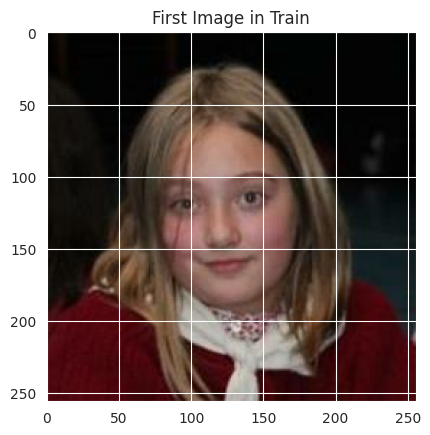

In [ ]:
# Retrieve the first image and label from train
image_batch, labels_batch = next(iter(train))
first_image = image_batch[0]
first_label = labels_batch[0]

# Convert the image tensor to a numpy array
first_image_np = first_image.numpy() * 1./255

# Display the image
plt.imshow(first_image_np)
plt.title('First Image in Train')
plt.show();